In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Latex, Markdown
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os
import json
import pandas as pd

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils import DDR_f as DDR_f_np
from masa_utils import Pelton_res_f as Pelton_np
from masa_utils import InducedPolarizationSimulation as IPsim_np
from masa_utils import Optimization as Opt_np
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, DDR_f, DDC_f, DDP_r_f
from masa_utils_pytorch import Optimization, TorchHelper
 

# impacts of the time range

In [4]:
res0= 0.3
res_ref = 0.3
eta= 0.4
expc= 0.4
tau= 3.0e-2 #0.001
taupel = tau
parm_true = TorchHelper.to_tensor_r([np.log(res0), eta, np.log(taupel), expc])


In [5]:
# taus_strt_log = -3.5
# taus_end_log  = -1.75
# taus_step_log = 0.25
# taus= 10**np.arange(taus_strt_log, taus_end_log+ taus_step_log, taus_step_log)
# ntau= len(taus)
# freq_step_log  = 0.1
# freq = 10**np.arange(-taus_end_log, -taus_strt_log+freq_step_log, freq_step_log)
# freq /= 2.0*np.pi
# nfreq=len(freq)
# nmodel = 3

# freq_eps = np.finfo(float).eps
# freq_cmb = []
# taus_cmb= []
# ntau_cmb = []
# titles = []

# for i in range(nmodel):


#     freq_cmb.append(freq)
#     taus_cmb.append(taus)

#     ntau = len(taus_cmb[i])
#     ntau_cmb.append(ntau)


#     title=fr"Max $\tau_j$ : $10^{{{taus_end_log}}}$ s"
#     titles.append(title)

In [6]:
nmodel = 3

taus_start_log = -5*np.ones(nmodel)
taus_end_log   = [-2, 0, 2]  
taus_step_log = 0.5
freq_step_log  = 0.1
freq_eps = np.finfo(float).eps
freq_cmb = []
taus_cmb= []
ntau_cmb = []
titles = []

for i in range(nmodel):

    ntau = int(round((taus_end_log[i] - taus_start_log[i]) / taus_step_log)) + 1
    taus = np.logspace(taus_start_log[i], taus_end_log[i], ntau, base=10.0)
    nfreq = int(round((taus_end_log[i]-taus_start_log[i]) / freq_step_log)) + 1
    freq = np.logspace(-taus_end_log[i], -taus_start_log[i], nfreq, base=10.0) / (2.0*np.pi)

    assert np.isclose(freq.min(), 10**(-taus_end_log[i])/(2.0*np.pi))
    assert np.isclose(freq.max(), 10**(-taus_start_log[i])/(2.0*np.pi))

    freq_cmb.append(freq)
    taus_cmb.append(taus)

    title=fr"Max $\tau_j$ : $10^{{{taus_end_log[i]}}}$ s"
    titles.append(title)
    ntau = len(taus_cmb[i])
    ntau_cmb.append(ntau)



In [7]:
titles

['Max $\\tau_j$ : $10^{-2}$ s',
 'Max $\\tau_j$ : $10^{0}$ s',
 'Max $\\tau_j$ : $10^{2}$ s']

In [8]:
relative_error = 0.02
noise_floor_ratio = 1e-3
niter = 100
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


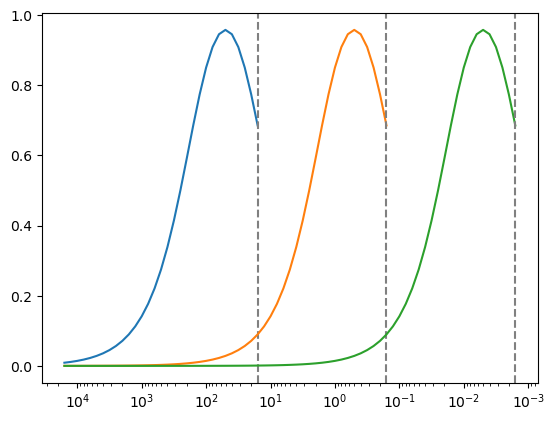

In [9]:
fig, ax = plt.subplots()

dobs_cmb =[]
rho0_recs = []
eta_recs = []
sim_invs = []
parm_refs = []
noise_floor_cmb = []
for i in range(nmodel):
    freq = freq_cmb[i]
    taus = taus_cmb[i]
    ntau = ntau_cmb[i]
    nfreq = freq.shape[0]
    IP_model = Pelton(freq=freq)
    sim_obs = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    dobs = sim_obs.dpred(parm_true).detach()
    f_abs = abs(IP_model.f(parm_true)).detach().numpy()
    rho0, rho8 = f_abs.max(), f_abs.min()
    rho0_recs.append(rho0)
    eta_recs.append((rho0-rho8)/rho0) 

    dobs_cmb.append(dobs)
    noise_floor = torch.tensor(f_abs.max())* noise_floor_ratio
    noise_floor_cmb.append(noise_floor)
    IP_model = DDR_f(freq=freq, taus=taus)
    # IP_model = DDP_r_f(freq=freq,taus=taus)
    # IP_model = DDC_f(freq=freq, taus=taus, res=True)
    sim_inv = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

    sim_invs.append(sim_inv)
    parm_init = torch.tensor(
    # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
    np.r_[np.log(f_abs.max()), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
    ) #, requires_grad=False)
    parm_refs.append(parm_init)
    m= np.r_[np.log(0.3), np.zeros(len(taus)-1), 0.9]
    # m= np.r_[np.log(0.3), 0.9,  np.zeros(len(taus)-1)]
    m_tensor=TorchHelper.to_tensor_r(m)
    dpred = sim_inv.dpred(m_tensor)

    dpred_real = dpred[:nfreq]
    dpred_imag = dpred[nfreq:]
    dpred_phase= np.angle(dpred_real + 1.00j *dpred_imag)
    ax.semilogx(freq, -dpred_phase)
    # ax.axvline(x=(1/2/np.pi)*10**(-taus_end_log), color='gray', linestyle='--')
    ax.axvline(x=(1/2/np.pi)*10**(-taus_end_log[i]), color='gray', linestyle='--')
ax.invert_xaxis()        
plt.show()

In [10]:
dinit_refs = []
model_recs = []
dpreds = []
error_prgs = []
model_prgs = []
data_prgs =[]
sims = []
WdJs = []
J_etas_prd = []
for i in range(nmodel):
    freq = freq_cmb[i]
    taus = taus_cmb[i]
    nfreq = freq.shape[0]
    dobs = dobs_cmb[i]
    noise_floor = noise_floor_cmb[i]
    parm_init = parm_refs[i]
    sim = sim_invs[i]
    print(nfreq, len(dobs))
    # IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    # IP_model = DDR_f(freq=freq, taus=taus)
    # sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    # sims.append(sim)
    opt = Optimization(sim=sim, dobs=dobs)
    opt.get_Wd(ratio=relative_error, plateau=noise_floor)

    jacobian = opt.J(parm_refs[i])
    WdJs.append(opt.Wd@jacobian)
    J_etas_prd.append(sim.J_prd(opt.Wd@jacobian))

    opt.Ws = torch.eye(len(parm_init))
    beta0 = opt.BetaEstimate_byEig(eig_tol=1e-6,
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GaussNewton(
    mvec_init=parm_init,niter=niter,beta0=beta0,L1reg=False,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    stol=stol,update_Wsen=True)

    dinit_refs.append(opt.dpred(parm_init))
    model_recs.append(mpred)
    dpreds.append(opt.dpred(mpred))
    error_prgs.append(opt.error_prg)
    model_prgs.append(opt.mvec_prg)
    data_prgs.append(opt.data_prg)

31 62
tensor(85666024.)
  0, beta:8.6e+07, phid:1.6e+04,    phim:0.0e+00, f:1.6e+04
  1, beta:8.6e+07, step:1.0e+00, gradient:3.4e+05, f:1.5e+04
  2, beta:8.6e+07, step:1.0e+00, gradient:1.9e+03, f:1.5e+04
  3, beta:4.3e+07, step:1.0e+00, gradient:1.6e+05, f:1.4e+04
  4, beta:4.3e+07, step:1.0e+00, gradient:1.5e+03, f:1.4e+04
  5, beta:2.1e+07, step:1.0e+00, gradient:1.5e+05, f:1.2e+04
  6, beta:2.1e+07, step:1.0e+00, gradient:2.2e+03, f:1.2e+04
  7, beta:1.1e+07, step:1.0e+00, gradient:1.3e+05, f:1.0e+04
  8, beta:1.1e+07, step:1.0e+00, gradient:2.7e+03, f:1.0e+04
  9, beta:5.4e+06, step:1.0e+00, gradient:1.1e+05, f:7.6e+03
 10, beta:5.4e+06, step:1.0e+00, gradient:2.5e+03, f:7.6e+03
 11, beta:2.7e+06, step:1.0e+00, gradient:7.7e+04, f:5.1e+03
 12, beta:2.7e+06, step:1.0e+00, gradient:1.6e+03, f:5.0e+03
 13, beta:1.3e+06, step:1.0e+00, gradient:5.0e+04, f:3.0e+03
 14, beta:1.3e+06, step:1.0e+00, gradient:7.6e+02, f:3.0e+03
 15, beta:6.7e+05, step:1.0e+00, gradient:2.9e+04, f:1.7e+03
 

In [11]:
phid_star_ratio =1.0
models_rec_phid = []
dpreds_phid = []

for i in range(nmodel):
    sim = sim_invs[i]
    freq = freq_cmb[i]
    taus = taus_cmb[i]
    nfreq = freq.shape[0]
    phid_star = nfreq*2
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star * phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
    models_rec_phid.append(model_prg[ind][0])
    model_rec = TorchHelper.to_tensor_r(model_prg[ind][0])
    dpred = sim.dpred(model_rec)
    dpreds_phid.append(dpred.detach().numpy())
    # dpreds_phid.append(data_prg[ind][0])


In [12]:
models_rec_phid

[array([-1.4250238 ,  0.00954811,  0.01027665,  0.01627441,  0.02483693,
         0.03358316,  0.05074072,  0.09399639], dtype=float32),
 array([-1.2529876 ,  0.00768735,  0.00871995,  0.01338914,  0.02033281,
         0.02947715,  0.04014836,  0.04944659,  0.05282615,  0.04773237,
         0.03892795,  0.03955052], dtype=float32),
 array([-1.2106056 ,  0.00733792,  0.00837802,  0.01287045,  0.01954139,
         0.02833261,  0.0385777 ,  0.04742687,  0.0507296 ,  0.04664476,
         0.03754437,  0.02748467,  0.01898964,  0.01241104,  0.00785985,
         0.00867506], dtype=float32)]

In [13]:
print( "obs_0 & &  obs_1")
np_mvec_refs= []
np_mvec_ests= []
model_name =["too small ", "just right", "too large "]
data = []
for i in range(nmodel):
    name = model_name[i]
    # np_mvec_ref = parm_refs[i].detach().numpy()
    rho0_0 = np.exp(models_rec_phid[i][0])
    eta_0 = models_rec_phid[i][1:].sum()
    data.append

    # m_est_phid = models_rec_phid[i]
    print(fr"{name} & $\rho_0$        & {rho0_0:.2e}   \\")
    print(fr"           & $\sum\eta_j$    & {eta_0:.3f} \\")
    print(r"\hline")

print


obs_0 & &  obs_1
too small  & $\rho_0$        & 2.41e-01   \\
           & $\sum\eta_j$    & 0.239 \\
\hline
just right & $\rho_0$        & 2.86e-01   \\
           & $\sum\eta_j$    & 0.348 \\
\hline
too large  & $\rho_0$        & 2.98e-01   \\
           & $\sum\eta_j$    & 0.373 \\
\hline


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [14]:
rho0_invs = []
eta_invs = []

for i in range(nmodel):
    rho0_inv = np.exp(models_rec_phid[i][0])
    eta_inv = models_rec_phid[i][1:].sum()
    rho0_invs.append(rho0_inv)
    eta_invs.append(eta_inv)

In [15]:
# for row in [rho0_invs, rho0_recs, eta_invs, eta_recs]:
#     formatted = [f"{x:.1e}" for x in row[:2]]
#     formatted.append([f"{x:.2d}" for x in row[2:]])
#     print(" & ".join(formatted) + r" \\")

In [16]:
# for name, row in zip(
#     [r"$\rho_0$ from DD inversion", r"$\rho_0$ accords to FB",
#      r"$\sum \eta$ from DD inversion", r"$\eta$ accords to FB"],
#     [rho0_invs, rho0_recs, eta_invs, eta_recs]
# ):
#     # choose format depending on whether it’s rho0 or eta
#     if "eta" in name:
#         formatted = [f"{x:.2f}" for x in row]  # η values → 2 decimal places
#     else:
#         formatted = [f"{x:.1e}" for x in row]  # ρ₀ values → scientific notation
#     print(f"{name} & {' & '.join(formatted)} \\\\")

In [17]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
dobs_abs_np =[]
dobs_phase_np =[]
for i in range(nmodel):
    # dest = dpreds[i].detach().numpy()
    freq = freq_cmb[i]
    nfreq = freq.shape[0]
    dest = dpreds_phid[i]
    dinit = dinit_refs[i].detach().numpy()
    dobs = dobs_cmb[i].detach().numpy()
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dobs_np = dobs_cmb[i].detach().numpy()
    dobs_real = dobs_np[:nfreq]
    dobs_imag = dobs_np[nfreq:]
    dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
    dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
    dobs_abs_np.append(dobs_abs)
    dobs_phase_np.append(dobs_phase)

    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)



In [18]:
def plot_sip(freq, dpreds, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(5,3))
    nfreq = len(freq)

    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    nfreq = len(dpreds)//2

    sip_real = dpreds[:nfreq]
    sip_imag = dpreds[nfreq:]
    sip_abs = np.abs(sip_real + 1j * sip_imag)
    sip_phs = np.angle(sip_real + 1j * sip_imag, deg=True)
    ax[0].semilogx(freq, sip_abs, **default_kwargs)
    ax[1].semilogx(freq, sip_phs, **default_kwargs)

    ax[0].set_ylim(bottom=0)

    ax[0].set_ylabel(r'$|\rho^{\ast}|~(\Omega\cdot\mathrm{m})$')

    ax[1].set_ylabel(r'$\phi~(^\circ)~(\mathrm{deg}) $')


    for a in ax:
        a.set_xlabel("Frequency [Hz]")

    return ax

In [19]:
def plot_etas_model(model,taus, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    etas = model[1:]
    ax.semilogx(taus, etas, **kwargs)
    ax.set_xlabel(r"$\tau_j$ [s]")
    ax.set_ylabel(r"$\eta_j$")
    return ax

C:\Users\81805\AppData\Local\Temp\ipykernel_27376\4055316455.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sip_abs = np.abs(sip_real + 1j * sip_imag)


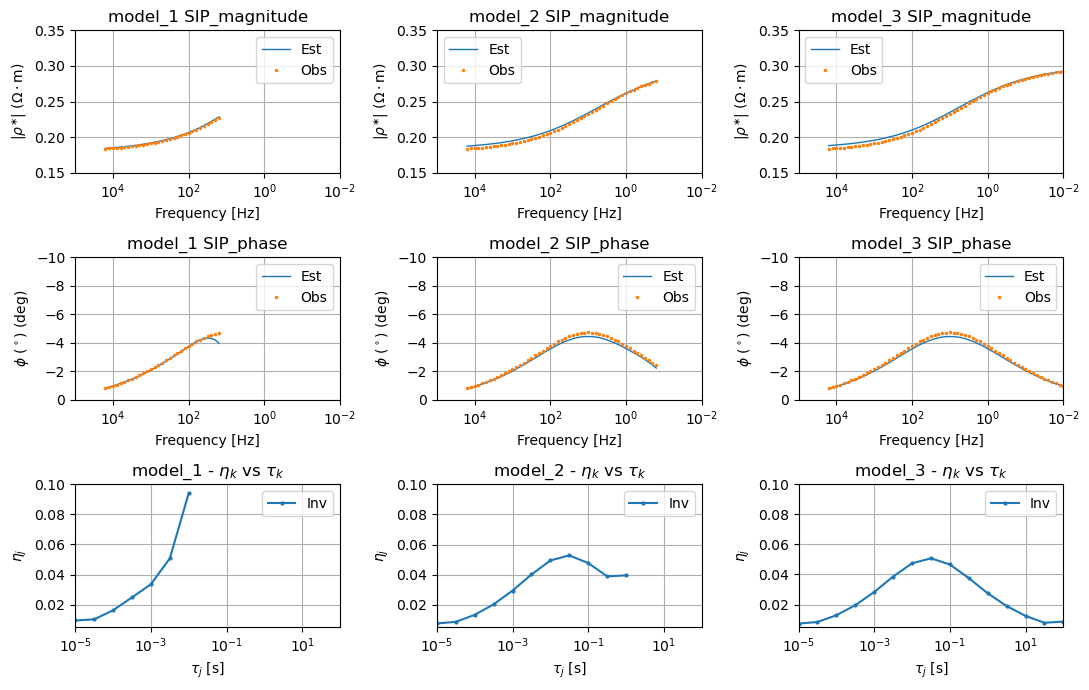

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(11,7))
title_heads = ["model_1", "model_2", "model_3"]
ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nmodel):
    title_head = title_heads[i]
    ax_range = ax_ranges[i]
    axsip = [ax_range[0], ax_range[1]]
    axetas = ax_range[2]
    axsip = plot_sip(freq_cmb[i], dpreds_phid[i], 
             ax=axsip, color="C0", label=f"Est", linestyle="-"
             )
    axetas = plot_etas_model(models_rec_phid[i], taus_cmb[i],
             ax=axetas, color="C0", label=f"Inv", linestyle="-",
             marker=".", markersize= 4.
             )
                             
    # axtmp = plot_each_model(freq_cmb[i+nrange],
    #          dpreds_phid[i+nrange], models_rec_phid[i+nrange], taus_cmb[i+nrange],
    #          ax=axtmp, color="C1", label=f"Estimated_fixed", linestyle="--"
    #          )
    axsip  = plot_sip(freq=freq_cmb[i],
              dpreds=dobs_cmb[i],ax=axsip, color="C1", label=f"Obs", linestyle="",
              marker='.', markersize=3
              )
    # axetas = plot_etas_model(models_rec_phid[i+nrange], taus_cmb[i+nrange],
    #          ax=axetas, color="C1", label=f"True", linestyle=":" ,
    #          marker=".", markersize= 4.
    #         )

    axsip[0].set_ylim(bottom=0.15,top=0.35)
    axsip[0].set_xlim(left=1e5, right=0.01)
    axsip[1].set_ylim(top=-10, bottom=0)
    axsip[1].set_xlim(left=1e5, right=0.01)
    axetas.set_xlim(left=1e-5, right=1e+2)
    axetas.set_ylim(top=0.10)

    for a in ax_range:
        a.legend()
        a.grid()
    ax_range[0].set_title(f"{title_head} SIP_magnitude")
    ax_range[1].set_title(f"{title_head} SIP_phase")
    ax_range[2].set_title(fr"{title_head} - $\eta_k$ vs $\tau_k$")
plt.tight_layout()
plt.savefig('42_DD_SIP.jpg', dpi=300)

In [ ]:
# sip_true_inv = models_rec_phid[0]
# print(sip_true_inv)
# np.save('42_DD_SIP.npy', models_rec_phid[0])

In [ ]:
Cnds= []
for i in range(nmodel):
    WdJ = WdJs[i].detach().numpy()
    U, S, V = np.linalg.svd(WdJ)
    S_norm = S / np.max(S)
    Cnds.append(S_norm)


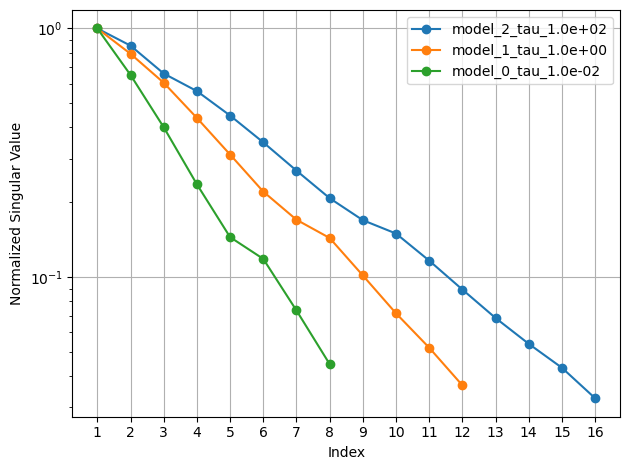

In [ ]:
labels= [f""]
index_max=0
for i in np.arange(nmodel-1,-1,-1):
    Cnd = Cnds[i]
    plt.semilogy(Cnd, marker="o",
                 label =f'model_{i}_tau_{taus_cmb[i].max():.1e}')
    index_max = max(index_max, len(Cnd))

plt.xticks(np.arange(index_max), np.arange(1, index_max+1))
plt.xlabel("Index")
plt.ylabel("Normalized Singular Value")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('42_DD_Cnd.jpg', dpi=300)

In [ ]:
array = np.arange(4,-1,-1)
print(array)

[4 3 2 1 0]


Repeat with numpy 

In [ ]:
res0= 0.3
res_ref = 0.3
eta= 0.6
expc= 0.4
tau= 1.0 #0.001
taupel = tau
parm_true = [np.log(res0), eta, np.log(taupel), expc]


In [ ]:
# dobs_cmb =[]
# sim_inv_np = []
# parm_refs = []
# noise_floor_cmb = []
# for i in range(nmodel):
#     freq = freq_cmb[i]
#     taus = taus_cmb[i]
#     ntau = ntau_cmb[i]
#     nfreq = freq.shape[0]
#     IP_model = Pelton_np(freq=freq)
#     sim_obs = IPsim_np(ip_model=IP_model, mode="sip")
#     dobs = sim_obs.dpred(parm_true)
#     f_abs = abs(IP_model.f(parm_true)) 
#     np.random.seed(0)
#     noise_floor = f_abs.max()* noise_floor_ratio

#     if i < nrange:

#         dobs +=  np.random.randn(len(dobs)) * np.sqrt(
#                 (relative_error * abs(dobs))**2
#                 + (noise_floor*np.ones(len(dobs)))**2
#                 )

#     dobs_cmb.append(dobs)
#     noise_floor_cmb.append(noise_floor)
#     IP_model = DDR_f_np(freq=freq, taus=taus)
#     sim = IPsim_np(ip_model=IP_model, mode="sip")

#     sim_inv_np.append(sim)
#     parm_init = np.r_[np.log(f_abs.max()), np.zeros(ntau)]
#     parm_refs.append(parm_init)


In [ ]:
# fig, ax = plt.subplots(2,3, figsize=(15,8))
# for i in range(nrange):
#     freq = freq_cmb[i]
#     nfreq = len(freq)
#     dobs = dobs_cmb[i]

#     dobs_real = dobs[:nfreq]
#     dobs_imag = dobs[nfreq:]
#     dobs_abs = abs(dobs_real + 1.0j* dobs_imag)
#     dobs_phase = np.angle(dobs_real + 1.0j* dobs_imag,  deg =True)
#     ax[0, i]. semilogx(freq, dobs_abs,color="C0" ,label="Observed")
#     ax[1, i]. semilogx(freq, dobs_phase,color="C0", label="Observed")
#     freq = freq_cmb[i+nrange]
#     nfreq = len(freq)
#     dobs = dobs_cmb[i+nrange]
#     dobs_real = dobs[:nfreq]
#     dobs_imag = dobs[nfreq:]
#     dobs_abs = abs(dobs_real + 1.0j* dobs_imag)
#     dobs_phase = np.angle(dobs_real + 1.0j* dobs_imag,  deg =True)
#     ax[0, i]. semilogx(freq, dobs_abs,color="C1", linestyle = "--", label="Clean")
#     ax[1, i]. semilogx(freq, dobs_phase,color="C1", linestyle = "--", label="Clean")
#     ax[0,i].invert_xaxis()
#     ax[0,i].set_ylim(bottom=0, top=0.25)
#     ax[1,i].invert_xaxis()
#     ax[1,i].invert_yaxis()

# for a in ax.flat:
#     a.legend()
#     a.set_xlim(left=1e5, right=1e-1)


In [ ]:
# dinit_refs = []
# model_recs = []
# dpreds = []
# error_prgs = []
# model_prgs = []
# data_prgs =[]
# sims = []
# WdJs = []
# J_etas_prd = []
# for i in range(nmodel):
#     freq = freq_cmb[i]
#     taus = taus_cmb[i]
#     nfreq = freq.shape[0]
#     dobs = dobs_cmb[i]
#     noise_floor = noise_floor_cmb[i]
#     parm_init = parm_refs[i]
#     sim = sim_inv_np[i]
#     print(nfreq, len(dobs))
#     # IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
#     # IP_model = DDR_f(freq=freq, taus=taus)
#     # sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
#     # sims.append(sim)
#     opt = Opt_np(sim=sim, dobs=dobs,eig_tol=1e-6,)
#     opt.get_Wd(ratio=relative_error, plateau=noise_floor)
#     opt.get_Ws(np.ones(len(parm_init)))

#     jacobian = opt.J(parm_refs[i])
#     WdJs.append(opt.Wd@jacobian)
#     J_etas_prd.append(sim.J_prd(opt.Wd@jacobian))

#     beta0 = opt.BetaEstimate_byEig(
#     mvec=parm_init, update_Wsen=True, beta0_ratio=beta0_ratio)
#     print(beta0)
#     mpred = opt.GaussNewton(
#     mvec_init=parm_init,niter=niter,beta0=beta0,
#     coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
#     stol=stol,update_Wsen=True)

#     dinit_refs.append(opt.dpred(parm_init))
#     model_recs.append(mpred)
#     dpreds.append(opt.dpred(mpred))
#     error_prgs.append(opt.error_prg)
#     model_prgs.append(opt.mvec_prg)
#     data_prgs.append(opt.data_prg)

In [ ]:
# phid_star_ratio = 1.0
# models_rec_phid = []
# dpreds_phid = []

# for i in range(nmodel):
#     sim = sim_inv[i]
#     freq = freq_cmb[i]
#     taus = taus_cmb[i]
#     nfreq = freq.shape[0]
#     phid_star = nfreq*2
#     model_prg= np.array(model_prgs[i])
#     data_prg = np.array(data_prgs[i])
#     error_prg = error_prgs[i]
#     phid_prg = np.array(error_prg)[:,1]
#     ind = phid_prg < phid_star * phid_star_ratio
#     if np.sum(ind) == 0:
#         ind = phid_prg == np.min(phid_prg)
#     models_rec_phid.append(model_prg[ind][0])
#     model_rec = TorchHelper.to_tensor_r(model_prg[ind][0])
#     dpred = sim.dpred(model_rec)
#     dpreds_phid.append(dpred)
#     # dpreds_phid.append(data_prg[ind][0])


In [ ]:
# print( "obs_0 & &  obs_1")
# np_mvec_refs= []
# np_mvec_ests= []
# model_name =["too small ", "just right", "too large "]
# for i in range(nrange):
#     # np_mvec_ref = parm_refs[i].detach().numpy()
#     rho0_0 = np.exp(models_rec_phid[i][0])
#     eta_0 = models_rec_phid[i][1:].sum()
#     rho_1 = np.exp(models_rec_phid[i+nrange][0])
#     eta_1 = models_rec_phid[i+nrange][1:].sum()
#     name = model_name[i]
#     # m_est_phid = models_rec_phid[i]
#     print(fr"{name} & $\rho_0$        & {rho0_0:.2e} & {rho_1:.2e} \\")
#     print(fr"           & $\sum\eta_j$    & {eta_0:.3f}  & {eta_1:.3f} \\")
#     print(r"\hline")


In [ ]:
# dest_abs_np =[]
# dest_phase_np =[]
# dest_real_np =[]
# dest_imag_np =[]
# dinit_abs_np =[]
# dinit_phase_np =[]
# dobs_abs_np =[]
# dobs_phase_np =[]
# for i in range(nmodel):
#     # dest = dpreds[i].detach().numpy()
#     freq = freq_cmb[i]
#     nfreq = freq.shape[0]
#     dest = dpreds_phid[i]
#     dinit = dinit_refs[i]
#     dobs = dobs_cmb[i]
#     dinit_real = dinit[:nfreq]
#     dinit_imag = dinit[nfreq:]
#     dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
#     dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
#     dobs_np = dobs_cmb[i]
#     dobs_real = dobs_np[:nfreq]
#     dobs_imag = dobs_np[nfreq:]
#     dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
#     dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)
#     dinit_abs_np.append(dinit_abs)
#     dinit_phase_np.append(dinit_phase)
#     dobs_abs_np.append(dobs_abs)
#     dobs_phase_np.append(dobs_phase)

#     dest_real = dest[:nfreq]
#     dest_imag = dest[nfreq:]
#     dest_abs = np.abs(dest_real + 1j * dest_imag)
#     dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
#     dest_real_np.append(dest_real)
#     dest_imag_np.append(dest_imag)
#     dest_abs_np.append(dest_abs)
#     dest_phase_np.append(dest_phase)



In [ ]:
# fig, ax = plt.subplots(3, 3, figsize=(11,7))
# titles = ["too small", "just right", "too large"]
# ax_range = []
# ax_range.append([ax[0, 0], ax[1, 0], ax[2, 0]])
# ax_range.append([ax[0, 1], ax[1, 1], ax[2, 1]])
# ax_range.append([ax[0, 2], ax[1, 2], ax[2, 2]])
# for i in range(nrange):
#     ax = ax_range[i]
#     axsip = [ax_range[i][0], ax_range[i][1]]
#     axetas = ax_range[i][2]
#     axsip = plot_sip(freq_cmb[i], dpreds_phid[i], 
#              ax=axsip, color="C0", label=f"Estimated", linestyle="-"
#              )
#     axetas = plot_etas_model(models_rec_phid[i], taus_cmb[i],
#              ax=axetas, color="C0", label=f"Inverted", linestyle="-",
#              marker=".", markersize= 4.
#              )
                             
#     # axtmp = plot_each_model(freq_cmb[i+nrange],
#     #          dpreds_phid[i+nrange], models_rec_phid[i+nrange], taus_cmb[i+nrange],
#     #          ax=axtmp, color="C1", label=f"Estimated_fixed", linestyle="--"
#     #          )
#     axsip  = plot_sip(freq=freq_cmb[i],
#               dpreds=dobs_cmb[i],ax=axsip, color="C1", label=f"Obs", linestyle="",
#               marker='.', markersize=3
#               )
#     axetas = plot_etas_model(models_rec_phid[i+nrange], taus_cmb[i+nrange],
#              ax=axetas, color="C1", label=f"True", linestyle=":" ,
#              marker=".", markersize= 4.
#             )

#     axsip[0].set_ylim(bottom=0.1,top=0.20)
#     axsip[0].set_xlim(left=1e5, right=1)
#     axsip[1].set_ylim(top=-10, bottom=0)
#     axsip[1].set_xlim(left=1e5, right=1)
#     axetas.set_xlim(left=1e-5, right=1e0)
#     axetas.set_ylim(top=0.2)
#     ax[0].set_title(titles[i])
#     for a in ax:
#         a.legend()
#         a.grid()

# plt.tight_layout()
# plt.savefig('42_DD_SIP_np.jpg', dpi=300)